In [41]:
import json

from torch.nn.quantized.functional import threshold

with open('../data/output/badminton/lanier_qi_detection_raw.json') as f:
    d = json.load(f)    

In [42]:
match_name = "lanier_qi"
pred_segs = []
segs = d["results"][match_name]
for seg in segs:
    pred_segs.append({"start": seg["segment"][0], "end": seg["segment"][1], "score": seg["score"]})

In [43]:
import pandas as pd

df = pd.DataFrame(pred_segs)
df

,start,end,score
0,11.765437,12.890096,0.287306
1,19.933846,21.204006,0.206040
2,3.865014,4.961907,0.139373
3,21.039192,22.137968,0.099632
4,31.254386,32.380405,0.277564
...,...,...,...
1239,5953.107892,5954.171830,0.091387
1240,5962.430165,5963.646153,0.465890
1241,5955.978836,5957.216056,0.425225
1242,5972.630566,5973.800762,0.042801


In [44]:
threshold = 0.9
df = df[df['score'] > threshold]

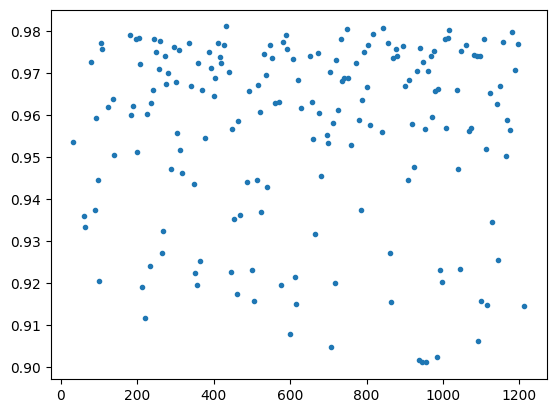

In [45]:
import matplotlib.pyplot as plt
plt.plot(df['score'], ".")

In [46]:
df = df.reset_index()
def ss_to_hhmmss(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"
df = df.assign(start_hhmmss=df['start'].apply(ss_to_hhmmss))
df = df.assign(end_hhmmss=df['end'].apply(ss_to_hhmmss))

In [47]:
df.tail

<bound method NDFrame.tail of      index        start          end     score start_hhmmss end_hhmmss
0       32   166.833856   168.798127  0.953569     00:02:46   00:02:48
1       60   301.672099   303.146022  0.936022     00:05:01   00:05:03
2       64   319.127711   321.565562  0.933433     00:05:19   00:05:21
3       80   392.523483   395.565829  0.972539     00:06:32   00:06:35
4       88   439.231808   444.397335  0.937284     00:07:19   00:07:24
..     ...          ...          ...       ...          ...        ...
179   1176  5660.205623  5666.065459  0.956414     01:34:20   01:34:26
180   1180  5681.496271  5686.456171  0.979620     01:34:41   01:34:46
181   1188  5703.845629  5709.324747  0.970601     01:35:03   01:35:09
182   1196  5752.083908  5757.295998  0.976935     01:35:52   01:35:57
183   1212  5817.671089  5824.789373  0.914459     01:36:57   01:37:04

[184 rows x 6 columns]>

In [48]:
merged_intervals = []

# Start with the first interval
current_start = df['start'].values[0]
current_end = df['end'].values[0]

# Iterate through the DataFrame rows
for i in range(1, len(df)):
    row_start = df.loc[i, 'start']
    row_end = df.loc[i, 'end']

    # If the current interval overlaps with the previous one, merge them
    if row_start <= current_end:
        current_end = max(current_end, row_end)  # Update the end of the merged interval
    else:
        # No overlap, add the previous interval and start a new one
        merged_intervals.append([current_start, current_end])
        current_start = row_start
        current_end = row_end

# Append the last interval
merged_intervals.append([current_start, current_end])

# Create a new DataFrame from the merged intervals
merged_df = pd.DataFrame(merged_intervals, columns=['start', 'end'])
merged_df = merged_df.assign(start_hhmmss=merged_df['start'].apply(ss_to_hhmmss))
merged_df = merged_df.assign(end_hhmmss=merged_df['end'].apply(ss_to_hhmmss))
merged_df

,start,end,start_hhmmss,end_hhmmss
0,166.833856,168.798127,00:02:46,00:02:48
1,301.672099,303.146022,00:05:01,00:05:03
2,319.127711,321.565562,00:05:19,00:05:21
3,392.523483,395.565829,00:06:32,00:06:35
4,439.231808,444.397335,00:07:19,00:07:24
...,...,...,...,...
133,5660.205623,5666.065459,01:34:20,01:34:26
134,5681.496271,5686.456171,01:34:41,01:34:46
135,5703.845629,5709.324747,01:35:03,01:35:09
136,5752.083908,5757.295998,01:35:52,01:35:57


In [9]:
# merged_df.to_csv(f'./data/{match_name}_hauptprojekt_full_match_binary.csv', index=False)

In [32]:
merged_df[['start_hhmmss', 'end_hhmmss']].to_csv(f'./trimming/data/{match_name}/clips.csv', index=False)

In [33]:
merged_df

,start,end,start_hhmmss,end_hhmmss
0,166.833856,168.798127,00:02:46,00:02:48
1,195.302826,196.488604,00:03:15,00:03:16
2,283.680988,285.186637,00:04:43,00:04:45
3,301.672099,303.146022,00:05:01,00:05:03
4,319.127711,321.565562,00:05:19,00:05:21
...,...,...,...,...
146,5703.818265,5709.324747,01:35:03,01:35:09
147,5732.438464,5733.692924,01:35:32,01:35:33
148,5752.083908,5757.295998,01:35:52,01:35:57
149,5784.412287,5824.789373,01:36:24,01:37:04
